In [1]:
# Import Dependencies
import os
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
from plotly.graph_objs import Scatter, Layout
import plotly.graph_objs as go

# Link to Plotly account
plotly_api = os.getenv('plotly_api')
py.tools.set_credentials_file(username='tli2001', api_key=plotly_api)
py.__version__

'2.5.0'

In [3]:
# Read in data.  Station Info is combined with Superbowl throughput data provided by Mayur
# Throughput definition: the number of people that click in/out of a station
csvpath = os.path.join('..','03_Data','station_info.csv')

# 2016 & 2015 data read in directly from Bart, used for heatmap
csv_2016 = pd.read_csv("http://64.111.127.166/origin-destination/date-hour-soo-dest-2016.csv.gz", names=['Date', 'time', 'Origin', 'Destination', 'Throughput',])
csv_2015 = pd.read_csv("http://64.111.127.166/origin-destination/date-hour-soo-dest-2015.csv.gz", names=['Date', 'time', 'Origin', 'Destination', 'Throughput',])
csv_2015.tail(2)

,Date,time,Origin,Destination,Throughput
10072501,2015-12-31,23,WOAK,POWL,24
10072502,2015-12-31,23,WOAK,RICH,1


In [4]:
pivot2016 = csv_2016.pivot_table(index=['Origin'], columns=['Destination'],values=['Throughput'],aggfunc=np.sum)
pivot2015 = csv_2015.pivot_table(index=['Origin'], columns=['Destination'],values=['Throughput'],aggfunc=np.sum)
pivot2015.head(2)

Throughput                                                      \
Destination       12TH    16TH    19TH   24TH   ASHB    BALB   BAYF   CAST   
Origin                                                                       
12TH             13671  104681   18753  88310  85521   45110  98991  30242   
16TH            111976   16167  145204  94657  87384  227593  37543  18970   

                             ...                                              \
Destination    CIVC   COLM   ...     ROCK   SANL   SBRN   SFIA   SHAY   SSAN   
Origin                       ...                                               
12TH         217667  31554   ...    62130  97309  26408  40798  44379  23311   
16TH         226728  52074   ...    77965  42446  46377  74150  20371  42003   

                                          
Destination   UCTY   WCRK   WDUB    WOAK  
Origin                                    
12TH         65615  83263  31956   35349  
16TH         22537  39610  19915  118467  

[2 rows x 45 columns]

In [9]:
# Read in stations data
bart_stations = pd.read_csv(csvpath, encoding = "utf-8")
bart_stations.head(1)

,Abbreviation,Description,Location,Name
0,12TH,"1245 Broadway, Oakland CA 94612<br />12th St. ...","-122.271450,37.803768,0",12th St. Oakland City Center (12TH)


In [10]:
# Set up station dataframe and separate out location coordinates for mapping purposes
station_locations = pd.DataFrame(bart_stations['Location'].str.split(',',2).tolist(),bart_stations['Abbreviation'])
station_locations.reset_index(inplace=True)
station_locations.columns = ['Station','lat','lon','x']
station_locations.head(2)

,Station,lat,lon,x
0,12TH,-122.271450,37.803768,0
1,16TH,-122.419694,37.765062,0


In [11]:
# Convert location coordinates to numeric values
station_locations['lat'] = pd.to_numeric(station_locations['lat'], downcast='float')
station_locations['lon'] = pd.to_numeric(station_locations['lon'], downcast='float')

# flip 'latitude' value in order for map to appear in the right direction
station_locations['lat'] = station_locations['lat']+180
station_locations.head(1)

,Station,lat,lon,x
0,12TH,57.728554,37.803768,0


In [12]:
# Read in Superbowl specific data - 2016 January/February throughput amounts provided by Mayur
csvpath_2016dest = os.path.join('2016 Throughput Destination pivot.csv')
csvpath_2016orig = os.path.join('2016 Throughput Origin pivot.csv')

# Also read in 2017 data of the same time frame for comparison purposes
csvpath_2017dest = os.path.join('2017 Throughput Destination pivot.csv')
csvpath_2017orig = os.path.join('2017 Throughput Origin pivot.csv')
#csvpath_2016dest

dest2016 = pd.read_csv(csvpath_2016dest, encoding = "utf-8")
orig2016 = pd.read_csv(csvpath_2016orig, encoding = "utf-8")
dest2017 = pd.read_csv(csvpath_2017dest, encoding = "utf-8")
orig2017 = pd.read_csv(csvpath_2017orig, encoding = "utf-8")
dest2016.head(1)

,Unnamed: 0,Destination,Throughput
0,0,12TH,666178


In [12]:
# no longer used - original plan was to merge mayur's 4 dataframes into my station dataframe
# decided it was easier to pull in the throughput column of each of the 4 dfs

#station_data = pd.merge(station_locations, dest2016, left_on="Station", right_on="Destination", how="left")
#station_data.head()

,Station,lat,lon,x,Unnamed: 0,Destination,Throughput
0,12TH,57.728554,37.803768,0,0.0,12TH,666178.0
1,16TH,57.580307,37.765060,0,1.0,16TH,680512.0
2,19TH,57.731400,37.808350,0,2.0,19TH,623175.0
3,24TH,57.581856,37.752468,0,3.0,24TH,674224.0
4,ASHB,57.729935,37.852802,0,4.0,ASHB,276731.0


In [13]:
# no longer used - originally needed to drop and rename columns after merging
#station_data = station_data.drop(columns=['x', 'Destination', 'Unnamed: 0'])
#station_data = station_data.rename(columns={"Throughput": "2016 Destination"})
#station_data.head()

,Station,lat,lon,2016 Destination
0,12TH,57.728554,37.803768,666178.0
1,16TH,57.580307,37.765060,680512.0
2,19TH,57.731400,37.808350,623175.0
3,24TH,57.581856,37.752468,674224.0
4,ASHB,57.729935,37.852802,276731.0


In [13]:
# new method was to create the four throughput columns and pull throughput totals in from their respective dfs
station_data = station_locations[['Station','lat','lon']]
station_data['2016 Origin'] = orig2016['Throughput']
station_data['2017 Origin'] = orig2017['Throughput']
station_data['2016 Destination'] = dest2016['Throughput']
station_data['2017 Destination'] = dest2017['Throughput']
station_data.head(2)

,Station,lat,lon,2016 Origin,2017 Origin,2016 Destination,2017 Destination
0,12TH,57.728554,37.803768,659535.0,624507,666178.0,632526
1,16TH,57.580307,37.765060,678521.0,617043,680512.0,622660


In [14]:
# locate the highest throughput of each throughput column
max2016dest = station_data['2016 Destination'].max()
max2016orig = station_data['2016 Origin'].max()
max2017dest = station_data['2017 Destination'].max()
max2017orig = station_data['2017 Origin'].max()

print(f"The highest throughput in 2016/2017 are: \n"
      f"2016 origin {max2016orig} destination {max2016dest} \n"
      f"2017 origin {max2017orig} destination {max2017dest} \n"
      f"16-17 difference: origin {max2016orig-max2017orig} destination {max2016dest-max2017dest}")

The highest throughput in 2016/2017 are: 
2016 origin 2000470.0 destination 2266562.0 
2017 origin 1899670 destination 2061536 
16-17 difference: origin 100800.0 destination 205026.0


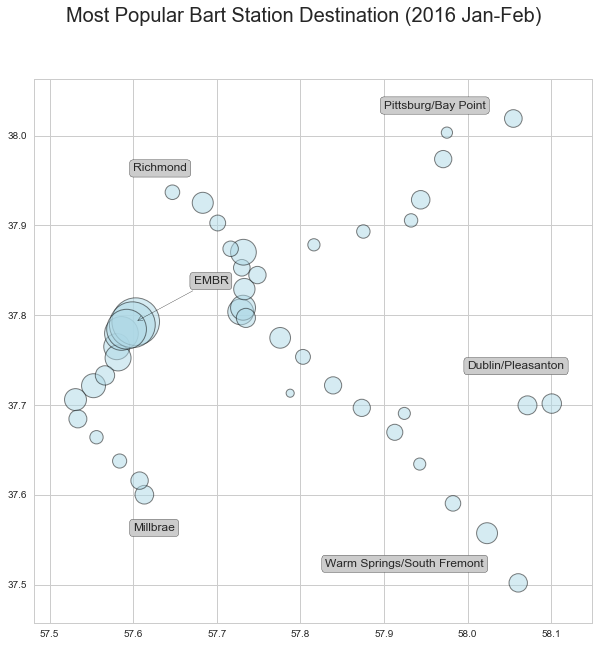

In [15]:
# Plot each station by their location information
# Plot 2016 station destination throughput data in a bubble plot

sns.set(style='whitegrid')
# plt.xlabel("", fontsize=20)
# plt.ylabel("", fontsize=20)
# plt.text(12,12, 'Approximate Location of each Bart Station')

fig, ax = plt.subplots(figsize=(10,10))
#plt.figure(figsize=(10,10))
fig.suptitle("Most Popular Bart Station Destination (2016 Jan-Feb)", fontsize=20)
#plt.title("Most Popular Bart Station Destination (2016 Jan-Feb)", fontsize=20)
ax.scatter(x=station_data['lat'], 
            y=station_data['lon'],
            s=station_data['2016 Destination']/1000,
            #figsize=(10,10),
            alpha=0.5, color='lightblue', edgecolor='black', linewidth=1)

bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")

ax.annotate(s="Richmond",bbox=bbox_args,xy=(57.6,37.96))
ax.annotate(s="Pittsburg/Bay Point",bbox=bbox_args,xy=(57.9,38.03))
ax.annotate(s="Dublin/Pleasanton",bbox=bbox_args,xy=(58.0,37.74))
ax.annotate(s="Warm Springs/South Fremont",bbox=bbox_args,xy=(57.83,37.52))
ax.annotate(s="Millbrae",bbox=bbox_args,xy=(57.6,37.56))

for i, txt in enumerate(station_data['Station']):
    x = (station_data['lat'][i]+0.2)
    y = (station_data['lon'][i]-0.2)
    if station_data['2016 Destination'][i] == max2016dest:
        ax.annotate(s=txt,
                    bbox=bbox_args,
                    arrowprops=arrow_args,
                    #xycoords='figure fraction',
                    xytext=(x, y), 
                    textcoords='offset points',
                    #xy=(x,y))
                    xy=(station_data['lat'][i],station_data['lon'][i]))

plt.savefig("2016populardestination")

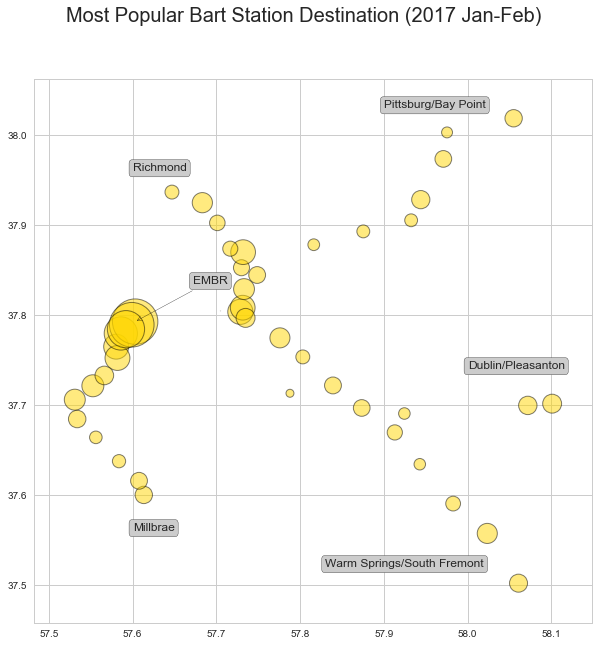

In [16]:
# Plot each station by their location information
# Plot 2017 station destination throughput data in a bubble plot

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle("Most Popular Bart Station Destination (2017 Jan-Feb)", fontsize=20)
ax.scatter(x=station_data['lat'], 
            y=station_data['lon'],
            s=station_data['2017 Destination']/1000,
            alpha=0.5, color='gold', edgecolor='black', linewidth=1)

bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")

ax.annotate(s="Richmond",bbox=bbox_args,xy=(57.6,37.96))
ax.annotate(s="Pittsburg/Bay Point",bbox=bbox_args,xy=(57.9,38.03))
ax.annotate(s="Dublin/Pleasanton",bbox=bbox_args,xy=(58.0,37.74))
ax.annotate(s="Warm Springs/South Fremont",bbox=bbox_args,xy=(57.83,37.52))
ax.annotate(s="Millbrae",bbox=bbox_args,xy=(57.6,37.56))

for i, txt in enumerate(station_data['Station']):
    x = (station_data['lat'][i]+0.2)
    y = (station_data['lon'][i]-0.2)
    if station_data['2017 Destination'][i] == max2017dest:
        ax.annotate(s=txt,
                    bbox=bbox_args,
                    arrowprops=arrow_args,
                    #xycoords='figure fraction',
                    xytext=(x, y), 
                    textcoords='offset points',
                    #xy=(x,y))
                    xy=(station_data['lat'][i],station_data['lon'][i]))

plt.savefig("2017populardestination")

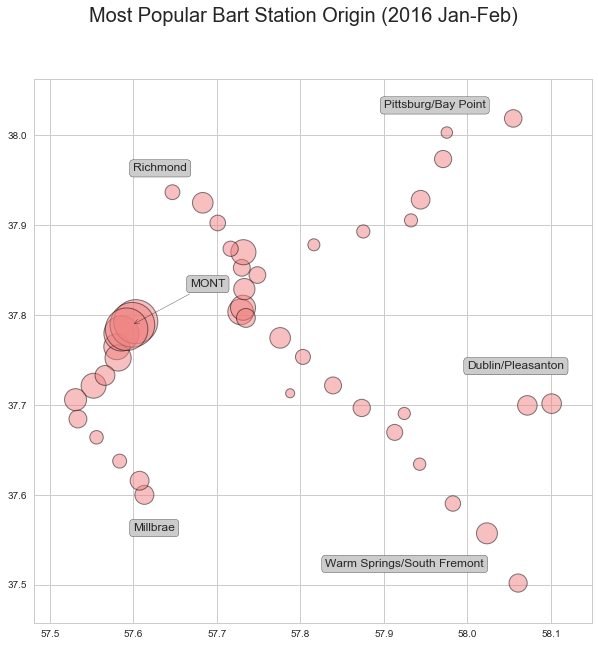

In [17]:
sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle("Most Popular Bart Station Origin (2016 Jan-Feb)", fontsize=20)
ax.scatter(x=station_data['lat'], 
            y=station_data['lon'],
            s=station_data['2016 Origin']/1000,
            alpha=0.5, color='lightcoral', edgecolor='black', linewidth=1)

bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")

ax.annotate(s="Richmond",bbox=bbox_args,xy=(57.6,37.96))
ax.annotate(s="Pittsburg/Bay Point",bbox=bbox_args,xy=(57.9,38.03))
ax.annotate(s="Dublin/Pleasanton",bbox=bbox_args,xy=(58.0,37.74))
ax.annotate(s="Warm Springs/South Fremont",bbox=bbox_args,xy=(57.83,37.52))
ax.annotate(s="Millbrae",bbox=bbox_args,xy=(57.6,37.56))

for i, txt in enumerate(station_data['Station']):
    x = (station_data['lat'][i]+0.2)
    y = (station_data['lon'][i]-0.2)
    if station_data['2016 Origin'][i] == max2016orig:
        ax.annotate(s=txt,
                    bbox=bbox_args,
                    arrowprops=arrow_args,
                    #xycoords='figure fraction',
                    xytext=(x, y), 
                    textcoords='offset points',
                    #xy=(x,y))
                    xy=(station_data['lat'][i],station_data['lon'][i]))

plt.savefig("2016popularorigin")

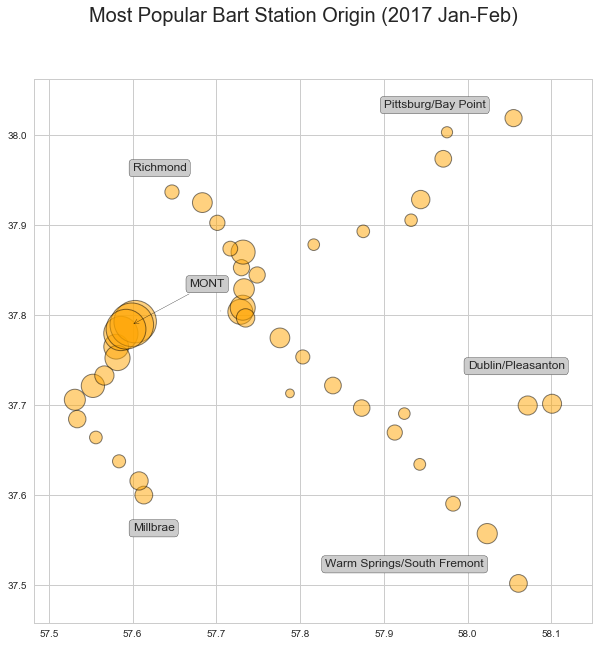

In [18]:
sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle("Most Popular Bart Station Origin (2017 Jan-Feb)", fontsize=20)
ax.scatter(x=station_data['lat'], 
            y=station_data['lon'],
            s=station_data['2017 Origin']/1000,
            alpha=0.5, color='orange', edgecolor='black', linewidth=1)

bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")

ax.annotate(s="Richmond",bbox=bbox_args,xy=(57.6,37.96))
ax.annotate(s="Pittsburg/Bay Point",bbox=bbox_args,xy=(57.9,38.03))
ax.annotate(s="Dublin/Pleasanton",bbox=bbox_args,xy=(58.0,37.74))
ax.annotate(s="Warm Springs/South Fremont",bbox=bbox_args,xy=(57.83,37.52))
ax.annotate(s="Millbrae",bbox=bbox_args,xy=(57.6,37.56))

for i, txt in enumerate(station_data['Station']):
    x = (station_data['lat'][i]+0.2)
    y = (station_data['lon'][i]-0.2)
    if station_data['2016 Origin'][i] == max2016orig:
        ax.annotate(s=txt,
                    bbox=bbox_args,
                    arrowprops=arrow_args,
                    #xycoords='figure fraction',
                    xytext=(x, y), 
                    textcoords='offset points',
                    #xy=(x,y))
                    xy=(station_data['lat'][i],station_data['lon'][i]))

plt.savefig("2017popularorigin")

In [19]:
# structure check of pivoted dataframes
pivot2016.columns
#pivot2016_copy = pivot2016.copy()

MultiIndex(levels=[['Throughput'], ['12TH', '16TH', '19TH', '24TH', 'ASHB', 'BALB', 'BAYF', 'CAST', 'CIVC', 'COLM', 'COLS', 'CONC', 'DALY', 'DBRK', 'DELN', 'DUBL', 'EMBR', 'FRMT', 'FTVL', 'GLEN', 'HAYW', 'LAFY', 'LAKE', 'MCAR', 'MLBR', 'MONT', 'NBRK', 'NCON', 'OAKL', 'ORIN', 'PHIL', 'PITT', 'PLZA', 'POWL', 'RICH', 'ROCK', 'SANL', 'SBRN', 'SFIA', 'SHAY', 'SSAN', 'UCTY', 'WCRK', 'WDUB', 'WOAK', 'WSPR']],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]],
           names=[None, 'Destination'])

In [20]:
# re-formatting data into the required structure for plotly (thanks Sasha for helping!)
s2016 = list(pivot2016["Throughput"].columns)
s2015 = list(pivot2015["Throughput"].columns)
j2016 = pivot2016.values.tolist()
j2015 = pivot2015.values.tolist()

In [21]:
# use Plotly to plot heatmap of traffic between stations for all of 2016
trace = go.Heatmap(z=j2016,
                   x=s2016,
                   y=s2016)
data=[trace]
py.plotly.iplot(data, filename='2016stationheatmap')

In [22]:
# repeat heatmap for 2015 data
trace2 = go.Heatmap(z=j2015,
                   x=s2015,
                   y=s2015)
data2=[trace2]
py.plotly.iplot(data2, filename='2015stationheatmap')

In [39]:
# Calculating difference in throughput between 2016 and 2017 January-February
station_data['OrigChange'] = station_data['2016 Origin'] - station_data['2017 Origin']
station_data['DestChange'] = station_data['2016 Destination'] - station_data['2017 Destination']
stations = list(station_data['Station'])
avg_orig_chg = station_data['OrigChange'].mean()
avg_dest_chg = station_data['DestChange'].mean()
print(f"Average change in throughput between Jan-Feb in 2016 and 2017 \n"
      f"Origin Station: {avg_orig_chg} Destination Station: {avg_dest_chg}")

Average change in throughput between Jan-Feb in 2016 and 2017 
Origin Station: 33640.555555555555 Destination Station: 33640.6


##### Below section used for experimenting - not used for project

In [42]:
# Plotting the change in the throughput in each station between Jan-Feb 2016 and 2017 
# Not included in project - looks too similar to Mayur's file

trace3 = go.Bar(
    x=stations,
    y=station_data['OrigChange'],
    name="Origin Station Change"
)
trace4 = go.Bar(
    x=stations,
    y=station_data['DestChange'],
    name="Destination Station Change"
)

#data3 = [trace3]
data34 = [trace3, trace4]

layout = go.Layout(
    title='Change in Throughput between Jan-Feb 2016 and 2017',
    xaxis=dict(
        title='Stations',
    ),
    yaxis=dict(
        title='Throughput',
    )
)
fig = go.Figure(data=data34, layout=layout)
py.plotly.iplot(fig, filename='ThroughputChange')
#plt.plot(y=station_data['OrigChange'],
#         x=stations, rotation='vertical')

In [32]:
# Playing around with Plotly - tried replicating geographic map using Plotly
#trace0 = go.Scattergeo(x=station_data['lat'], 
#                    y=station_data['lon'],
#                    #s=station_data['Throughput']/1000,
#                    #mode='markers',
#                    #marker=station_data['2016 Destination']/1000)
#                    mode='markers',
#                    marker=dict(size=[10, 50, 100, 150]),
#                   )
#
#data = [trace0]
#py.plotly.iplot(data, filename='2016populardestination')

In [49]:
pivot2016reset = pivot2016.reset_index()

In [56]:
pivot2016unstack = pivot2016.unstack()
type(pivot2016unstack)

pandas.core.series.Series

In [50]:
pivot2016reset.columns

MultiIndex(levels=[['Throughput', 'Origin'], ['12TH', '16TH', '19TH', '24TH', 'ASHB', 'BALB', 'BAYF', 'CAST', 'CIVC', 'COLM', 'COLS', 'CONC', 'DALY', 'DBRK', 'DELN', 'DUBL', 'EMBR', 'FRMT', 'FTVL', 'GLEN', 'HAYW', 'LAFY', 'LAKE', 'MCAR', 'MLBR', 'MONT', 'NBRK', 'NCON', 'OAKL', 'ORIN', 'PHIL', 'PITT', 'PLZA', 'POWL', 'RICH', 'ROCK', 'SANL', 'SBRN', 'SFIA', 'SHAY', 'SSAN', 'UCTY', 'WCRK', 'WDUB', 'WOAK', 'WSPR', '']],
           labels=[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [46, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]],
           names=[None, 'Destination'])

In [53]:
pivot2016['Throughput'][0]

KeyError: 0